In [66]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import json 
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import pandas as pd 
import numpy as np 
from catboost import Pool 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from ColumnTransformers import *
from sklearn import set_config
from IPython.display import display

In [67]:
def XgboostSearch(scale_pos_weight,df_X,y,metric="roc_auc"): 
    param_grid_xgb = {
        'n_estimators': [400,550,700],  
        'learning_rate': [0.0015,0.01],  
        'max_depth': [3,4,5,6], 
        'subsample': [1],  
        'colsample_bytree': [1.0],  
        'gamma': [0.2,0.4], 
        'reg_lambda': [1], 
        'scale_pos_weight':[scale_pos_weight,2*scale_pos_weight], # weight = 1 if negstive else wegiht=scale_pos_weight
        }  
    Lr=PipeLineGradient() 
    Lr.fit(df_X,y) 
    X=Lr.transform(df_X) 
    model=XGBClassifier()
    grid_search_xgb = GridSearchCV(model, param_grid_xgb, cv=5, scoring=metric, n_jobs=3)
    grid_search_xgb.fit(X,y)
    best_params=grid_search_xgb.best_params_
    with open("savedModels/XGBClassifier.json", "w") as f:
        json.dump(best_params, f, indent=4)    
    return  best_params

def LightgbmSearch(df_X,y,metric="roc_auc"):
    param_grid_lgb = {
        'n_estimators': [600,700,900],
        'learning_rate': [0.01],
        'max_depth': [2,3,4],
        'subsample': [1],
        'colsample_bytree': [0.8],
        'min_split_gain': [0.1],   # similar to gamma from XGB
        'reg_lambda': [1,3], 
        'is_unbalance':[True] }

    Lr=PipeLineGradient() 
    Lr.fit(df_X,y) 
    X=Lr.transform(df_X) 
    model=LGBMClassifier()
    grid_search_lgb = GridSearchCV(model, param_grid_lgb, cv=5, scoring=metric, n_jobs=3)
    grid_search_lgb.fit(X,y)
    best_params=grid_search_lgb.best_params_
    with open("savedModels/LGBMClassifier.json", "w") as f:
        json.dump(best_params, f, indent=4)
    return  best_params

def AdaSearch(df_X,y,metric='roc_auc') : 
    param_grid_ada = {
    'n_estimators': [70,100,120], 
    'learning_rate': [0.1,0.3],  # before amount of say
    'estimator': [DecisionTreeClassifier(max_depth=6), 
                          DecisionTreeClassifier(max_depth=7)
                 ]
    }
    Lr=PipeLineGradient() 
    Lr.fit(df_X,y) 
    X=Lr.transform(df_X) 
    model= AdaBoostClassifier()
    grid_search_ada = GridSearchCV(model, param_grid_ada, cv=5, scoring=metric, n_jobs=3)
    grid_search_ada.fit(X,y)
    best_params=grid_search_ada.best_params_
    serializable_params = {k: str(v) for k, v in best_params.items()}
    with open("savedModels/AdaBoost.json", "w") as f:
        json.dump(serializable_params, f, indent=4)
    print(f"Adaboost score: {123}")
    return best_params

In [68]:
def ReadCreateModel(modelName): 
    if modelName!="CatBoostClassifier":
        with open(f"savedModels/{modelName}.json", "r") as f:
            best_params=json.load(f) 
    if modelName == "AdaBoost":
            if "learning_rate" in best_params:
                best_params["learning_rate"] = float(best_params["learning_rate"])
            if "n_estimators" in best_params:
                best_params["n_estimators"] = int(best_params["n_estimators"])
            if "estimator" in best_params and isinstance(best_params["estimator"], str):
                estimator_str = best_params.pop("estimator")
                if estimator_str.startswith("DecisionTreeClassifier"):
                    estimator = eval(estimator_str) 
                else:
                    raise ValueError(f"Unsupported estimator: {estimator_str}")
                createdModel = AdaBoostClassifier(estimator=estimator)
            else:
                createdModel = AdaBoostClassifier()
    elif modelName=="XGBClassifier":
        createdModel=XGBClassifier(random_state=42, verbosity=0, n_jobs=-1)
    elif modelName=="LGBMClassifier":
        createdModel=LGBMClassifier(random_state=42 ,n_jobs=-1,verbosity=0)
    else:   
        with open(f"savedModels/{modelName}.json", "r") as f:
            data=json.load(f) 
            best_params = data["params"]
        createdModel=CatBoostClassifier(random_state=42,verbose=0)
    createdModel.set_params(**best_params) 
    return createdModel
    
def TestingModel(modelName,X_train,X_test,y_train,y_test,threshold ): 
    
    Model=ReadCreateModel(modelName) 
    if modelName!="CatBoostClassifier":
        Model=PipelineModel(Model)
        Model.fit(X_train,y_train) 
        y_scores=Model.predict_proba(X_test)[:, 1]
    else:
        X_train_transformed,cat_train=MergeNumCat(X_train)
        X_test_transformed,cat_test=MergeNumCat(X_test)
        pool_train=Pool(data=X_train_transformed,label=y_train,cat_features=cat_train)
        pool_test = Pool(data=X_test_transformed, cat_features=cat_test)
        Model.fit(pool_train)
        y_scores= Model.predict_proba(pool_test)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)

    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}, Recall: {recall_score(y_test,y_pred)}")
    return Model


def aucPlot(fpr,tpr,roc_auc): 
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray") 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.show()

In [69]:
def CatBoostTransformer(Numerical=['Transaction.Amount', 'Customer.Age','Account.Age.Days','Quantity']): 
    time_transformer=TimeTransformer(is_catboost=True)
    column_transformer = ColumnTransformer([
        ('time_features', time_transformer,["Transaction.Date","Transaction.Hour"]), 
        ("high_amount",HighAmountTransformer(),["Transaction.Amount"]),
        ("numerical",StandardScaler(),Numerical), 
        ("age",AgeTransfomer(),["Customer.Age"]), 
        ("dropColumns",'drop',["Transaction.Date","Transaction.Hour"])],remainder="passthrough") 
    return column_transformer

def MergeNumCat(X):
    CatTransformer=CatBoostTransformer() 
    CatTransformer.fit(X) 
    X_transformed=CatTransformer.transform(X)
    categorical=[col for col in range(X_transformed.shape[1]) if len(np.unique(X_transformed[:, col]))<6] 
    X_transformed[:, categorical]=X_transformed[:, categorical].astype(str)
    return X_transformed,categorical
    
def GetCategorical(X):
    categorical=[int(col) for col in range(X.shape[1]) if len(np.unique(X[:, col]))<6] 
    return categorical
    
def CatBoostSearch(X,y): 
    param_grid_cat = {
    'iterations': [1400,1500,1600],           # Number of boosting iterations (trees)
    'learning_rate': [0.01,0.015],     # Step size shrinkage
    'depth': [9,10,11],                      # Depth of each tree
    'l2_leaf_reg': [2],                # L2 regularization                          
    'auto_class_weights':['Balanced'],           # Class weight scaling (for imbalanced data)
    'grow_policy': ['SymmetricTree'],  
    'colsample_bylevel': [0.8],
    'border_count': [128,256]
    }
    X_train,cat_features=MergeNumCat(X)
    
    train_pool = Pool(data=X_train, label=y, cat_features=cat_features)
    
    model = CatBoostClassifier(verbose=0)
    
    grid_result=model.grid_search(param_grid_cat, X=train_pool, y=None,cv=5,refit=True)
    
    with open(f"savedModels/CatBoostClassifier.json", "w") as f:
        json.dump(grid_result, f, indent=4)
    return  grid_result


In [70]:
def GiantSearch(): 
    X,y=KCrossData()
    CatBoostSearch(X,y)
    XgboostSearch(GetScalePosWeight(y),X,y,metric='recall')
    LightgbmSearch(X,y,metric='recall')
    AdaSearch(X,y,metric='recall') 
    print("Well done") 
    return
def GiantSearchCatLGBM(): 
    X,y=KCrossData()
    CatBoostSearch(X,y)
    #LightgbmSearch(X,y,metric='recall')
    print("Well done") 
    return 

In [71]:
# GiantSearch()
#GiantSearchCatLGBM()

## FINAL MODEL

In [72]:

class CatBoostWithCatFeatures(CatBoostClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.cat_features_indices = None
    
    def fit(self, X, y=None, **fit_params):
        X_mod=self._preprocess(X)
        X_mod[:, self.cat_features_indices] = X_mod[:, self.cat_features_indices].astype(str)
        
        super().fit(X_mod, y, cat_features=self.cat_features_indices, **fit_params)
        return self

    def _preprocess(self, X):
        if self.cat_features_indices is None:
            self.cat_features_indices = GetCategorical(X)
        X_mod = X.copy()
        X_mod[:, self.cat_features_indices] = X_mod[:, self.cat_features_indices].astype(str)
        return X_mod

    def predict(self, X, **kwargs):
        X_mod = self._preprocess(X)
        return super().predict(X_mod, **kwargs)

    def predict_proba(self, X, **kwargs):
        X_mod = self._preprocess(X)
        return super().predict_proba(X_mod, **kwargs)
  
def CatBoostPipeline(X):
    catboost_pipeline = Pipeline([
    ("preprocessor", CatBoostTransformer(
        Numerical=['Transaction.Amount', 'Customer.Age','Account.Age.Days','Quantity']
        )),
    ("classifier", CatBoostWithCatFeatures(
        grow_policy="SymmetricTree",
        rsm=0.8,
        depth=9,
        auto_class_weights="Balanced",
        learning_rate=0.01,
        l2_leaf_reg=2,
        iterations=1500,
        border_count=256,
        verbose=0 ))])
    return catboost_pipeline

def LGBMClassifierPipeline(): 
    model=LGBMClassifier(
        colsample_bytree=0.8,
        is_unbalance=True,
        learning_rate=0.01,
        max_depth=2,
        min_split_gain=0.1,
        n_estimators=600,
        reg_lambda=1,
        subsample=1,
        verbosity=-1
    )
    result=PipelineModel(model)
    return result

def create_voting_classifier(X):
    
    catboost_pipeline = CatBoostPipeline(X)
    lgbm_pipeline = LGBMClassifierPipeline() 
    print(type(lgbm_pipeline))
    voting_ensemble = VotingClassifier(
        estimators=[
            ('catboost', catboost_pipeline),
            ('lgbm',     lgbm_pipeline)
        ],
        voting='soft'
    )
    return voting_ensemble

In [73]:
def FinalModel(X_train,X_test,y_train,y_test,threshold=0.5): 
    finalModel=create_voting_classifier(X_train)
    set_config(display='diagram')
    display(finalModel)
    finalModel.fit(X_train,y_train)
    y_scores=finalModel.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)
    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}")
    return finalModel

<class 'sklearn.pipeline.Pipeline'>


VotingClassifier(estimators=[('catboost',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('time_features',
                                                                                TimeTransformer(is_catboost=True),
                                                                                ['Transaction.Date',
                                                                                 'Transaction.Hour']),
                                                                               ('high_amount',
                                                                                HighAmountTransformer(),
                                                                                ['Transaction.Amount']),
                                                                               ('numerical',
                                                                                StandardScaler(),
                                                                                ['Transaction.Amount',
                                                                                 'Customer.Age'...
                                                                                 'source'])])),
                                              ('featureselection',
                                               RFE(estimator=LogisticRegression(C=0.1,
                                                                                class_weight='balanced',
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                                   n_features_to_select=30)),
                                              ('model',
                                               LGBMClassifier(colsample_bytree=0.8,
                                                              is_unbalance=True,
                                                              learning_rate=0.01,
                                                              max_depth=2,
                                                              min_split_gain=0.1,
                                                              n_estimators=600,
                                                              reg_lambda=1,
                                                              subsample=1,
                                                              verbosity=-1))]))],
                 voting='soft')

C:\Users\Ricardo\Programming\PycharmProjects\ML_Intro-Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


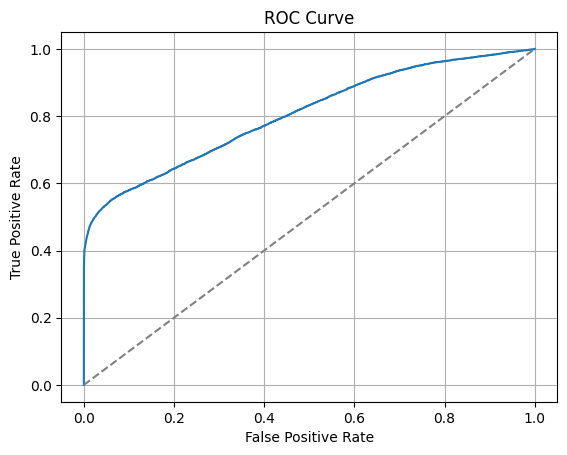

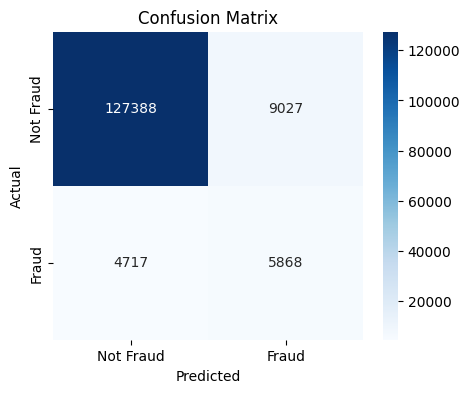

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95    136415
           1       0.39      0.55      0.46     10585

    accuracy                           0.91    147000
   macro avg       0.68      0.74      0.70    147000
weighted avg       0.92      0.91      0.91    147000

AUC: 0.8043865658972124


In [74]:
X_train,y_train=getTestData()
X_test,y_test=getTrainingData()
Model=FinalModel(X_train,X_test,y_train,y_test)